In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt


seed=42
ctb = CatBoostClassifier(random_seed=seed, silent=True)

#### Функции проще всего поместить в классы и из них вызывать
#### Но сейчас я их всех вынес в одно место, чтобы было удобно править и всё такое

In [164]:
def get_X_y(data):
    X, y = data.drop(columns="dep_delayed_15min"), data.dep_delayed_15min
    return X, y

In [411]:
def get_data(is_Kaggle, get_y=False):
    PATH_TO_DATA = Path('../input/focus-start-2020') if is_Kaggle \
                    else PATH("data")     
    X_train, y_train = get_X_y(pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv'))
    X_test = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')
    return X_train, y_train, X_test

In [75]:
def do_train_test(X: pd.DataFrame, y: pd.DataFrame, clf: CatBoostClassifier,
                  test_size=0.3, random_seed=None):
    print("start | ", end="")
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                        test_size=test_size, 
                                                        random_state=random_seed
                                                        )
    clf.fit(X_train, y_train, cat_features=get_cat_features(X))
    
    y_pred_train = ctb.predict_proba(X_train)[:, 1]
    y_pred_test = ctb.predict_proba(X_test)[:, 1]
    train_score = roc_auc_score(y_train, y_pred_train)
    test_score = roc_auc_score(y_test, y_pred_test)
    
    print("end")
    return train_score, test_score

In [80]:
def get_cat_features(data: pd.DataFrame):
    return np.where(data.dtypes == 'object')[0]

In [170]:
# Как показала практика в данной задачи простой tain test split 
# справляется на уровне cross-validation

folds = StratifiedKFold(shuffle=True, random_state=seed)

def get_cross_val_score(X, y, clf: CatBoostClassifier):
    cat_indexes = get_cat_features(X)
    history = list()
    X = X.values
    y = y.values
    i = 1
    for train_index, test_index in folds.split(X, y):
        print(f"{i} iteration start, ", end="")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train, cat_features=cat_indexes)
        
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]
        
        history.append(
            (roc_auc_score(y_train, y_pred_train),
             roc_auc_score(y_test, y_pred_test)
             )
        )
        
        print(f"{i} iteration end | ", end="")
        i += 1
    print()
    return history

In [97]:
def handle_distance(data):
    data.distance = np.log(data.distance)

In [129]:
def create_times_features(data: pd.DataFrame):
    data["hour"] = data.dep_time // 100
    data["minutes"] = data.dep_time % 100
    data["time_minute"] = data.hour * 60 + data.minutes
    data.drop(columns="dep_time", inplace=True)

In [90]:
def create_distance_features(data):
    data["path"] = data.origin + "-" + data.dest
    data["path_by"] = data.path + " by " + data.unique_carrier

In [413]:
def make_and_save_predict(smart_clf: CatBoostClassifier, X_test, file_name: str):
    y_pred_proba = smart_clf.predict_proba(X_test)[:, 1]
    sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv')
    sample_sub['Predicted'] = y_pred_proba
    sample_sub.to_csv(file_name, index=False)

____
___
___

In [412]:
X_train, y_train, X_test = get_data(True)

In [353]:
X_train.shape


(124397, 8)

In [209]:
X_train.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance  
0       546

In [207]:
pd.isna(X_train).sum()

month             0
day_of_month      0
day_of_week       0
unique_carrier    0
origin            0
dest              0
distance          0
hour              0
minutes           0
time_minute       0
dtype: int64

In [177]:
X_train.describe()

month   day_of_month    day_of_week       dep_time  \
count  124397.000000  124397.000000  124397.000000  124397.000000   
mean        6.584090      15.711577       3.927072    1335.104946   
std         3.371553       8.754423       1.985543     496.790767   
min         1.000000       1.000000       1.000000       1.000000   
25%         4.000000       8.000000       2.000000     920.000000   
50%         7.000000      16.000000       4.000000    1330.000000   
75%         9.000000      23.000000       6.000000    1740.000000   
max        12.000000      31.000000       7.000000    2400.000000   

            distance  
count  124397.000000  
mean      825.010483  
std       611.389317  
min        31.000000  
25%       372.000000  
50%       650.000000  
75%      1067.000000  
max      4983.000000

In [179]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124397 entries, 0 to 124396
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   month           124397 non-null  int64 
 1   day_of_month    124397 non-null  int64 
 2   day_of_week     124397 non-null  int64 
 3   dep_time        124397 non-null  int64 
 4   unique_carrier  124397 non-null  object
 5   origin          124397 non-null  object
 6   dest            124397 non-null  object
 7   distance        124397 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 7.6+ MB


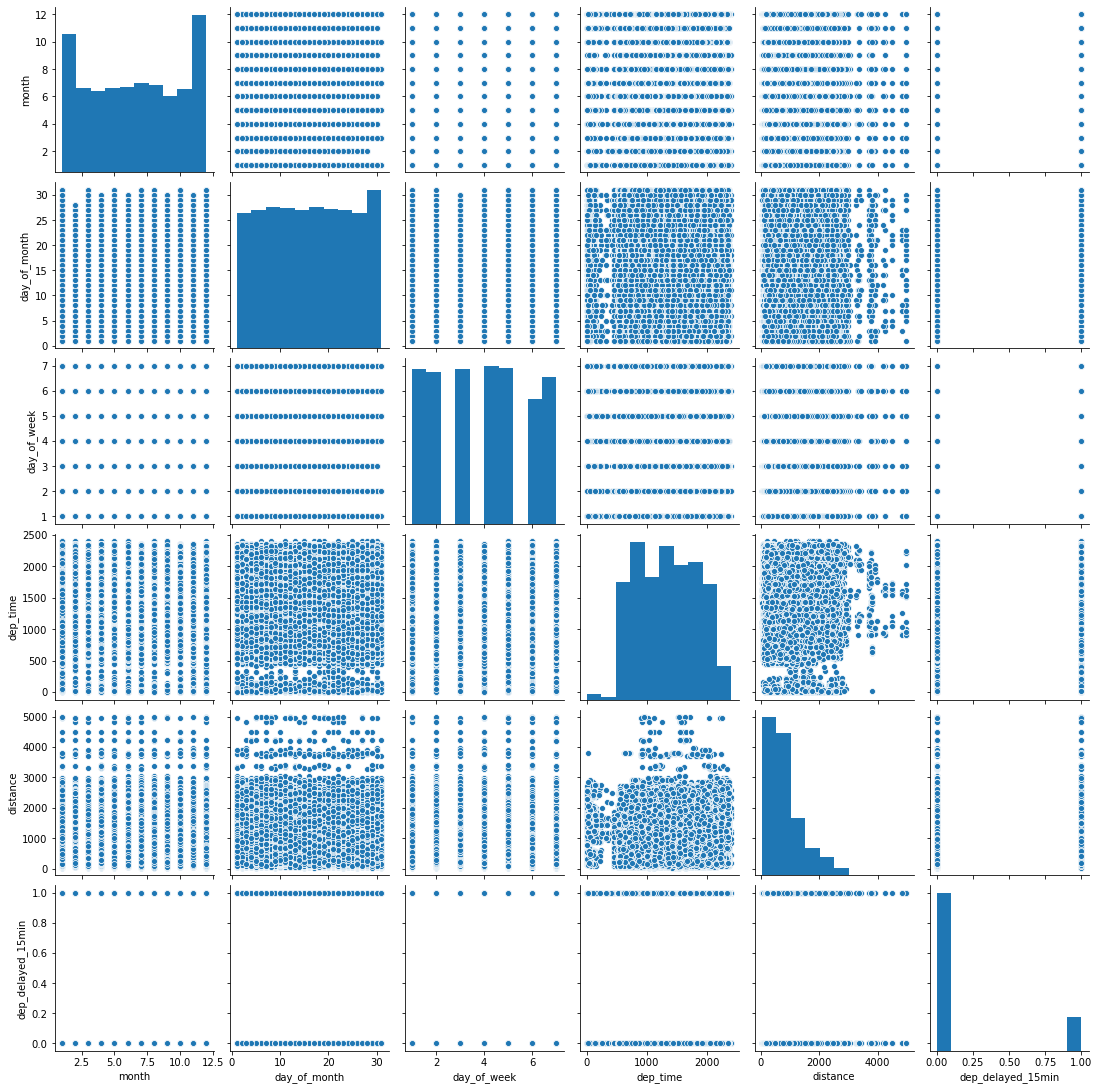

In [223]:
sns.pairplot(pd.concat((X_train, y_train), axis=1))

In [185]:
pd.concat((X_train, y_train), axis=1).corr()

month  day_of_month  day_of_week  dep_time  distance  \
month              1.000000      0.009667    -0.005582 -0.006104  0.009268   
day_of_month       0.009667      1.000000     0.002677 -0.000620  0.002402   
day_of_week       -0.005582      0.002677     1.000000  0.002209  0.016248   
dep_time          -0.006104     -0.000620     0.002209  1.000000 -0.015164   
distance           0.009268      0.002402     0.016248 -0.015164  1.000000   
dep_delayed_15min -0.041415     -0.001384    -0.010572  0.214626  0.018282   

                   dep_delayed_15min  
month                      -0.041415  
day_of_month               -0.001384  
day_of_week                -0.010572  
dep_time                    0.214626  
distance                    0.018282  
dep_delayed_15min           1.000000

In [189]:
pd.concat((X_train, y_train), axis=1).corr('spearman')

month  day_of_month  day_of_week  dep_time  distance  \
month              1.000000      0.009467    -0.005678 -0.006043  0.007597   
day_of_month       0.009467      1.000000     0.002601 -0.001095  0.003942   
day_of_week       -0.005678      0.002601     1.000000  0.002220  0.016914   
dep_time          -0.006043     -0.001095     0.002220  1.000000 -0.030084   
distance           0.007597      0.003942     0.016914 -0.030084  1.000000   
dep_delayed_15min -0.041619     -0.001347    -0.010564  0.219860  0.026328   

                   dep_delayed_15min  
month                      -0.041619  
day_of_month               -0.001347  
day_of_week                -0.010564  
dep_time                    0.219860  
distance                    0.026328  
dep_delayed_15min           1.000000

### Корреляции Пирсона и Спирмена показывают что целевая переменная зависит от времени отправления

По первому взгляду нет очевидных выбросов в численных признаках.
Что можно сделать:
- Создать baseline, относительно которого будем рассматривать изменения качества модели
- Перевести формат времени в часы и минуты
- Дистанция обычно имеет логнормальное распеределение, его можно привести в нормальное, но в случае catboost и решающих деревьев это раньше не давало изменений в метриках.
- Проверить гипотезы, например:
    - Есть плохая компания где есть больше всего задержек
    - Есть плохое направление где больше всего задержек
    - Есть оба случая сразу


Одним из лучших генераторов признаков является метод groupby

### Создадим baseline

In [24]:
# %%time
# result = get_cross_val_score(X_train, y_train, ctb)

1 iteration start, 1 iteration end | 2 iteration start, 2 iteration end | 3 iteration start, 3 iteration end | 4 iteration start, 4 iteration end | 5 iteration start, 5 iteration end | CPU times: user 21min 25s, sys: 2min 1s, total: 23min 26s
Wall time: 6min 17s


In [30]:
result

[(0.796726600739458, 0.7670263337758727),
 (0.8033937089792516, 0.74815161622902),
 (0.8048745133216653, 0.7527032703264315),
 (0.7985423922618821, 0.7548084372717456),
 (0.8027132771631895, 0.750225070766105)]

In [25]:
np.mean(result, axis=0)

array([0.8012501 , 0.75458295])

In [47]:
%%time
do_train_test(X_train, y_train, ctb, random_seed=seed)

start | end
CPU times: user 3min 50s, sys: 23 s, total: 4min 13s
Wall time: 1min 8s


(0.8018313309179812, 0.7555228286067397)

In [105]:
baseline = (0.8018313309179812, 0.7555228286067397)

### Time featrues

In [190]:
create_times_features(X_train)

In [191]:
X_train.head(1)

month  day_of_month  day_of_week unique_carrier origin dest  distance  \
0      4            16            4             OO    GEG  SLC       546   

   hour  minutes  time_minute  
0    13        9          789

### Distance

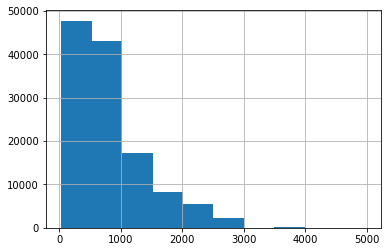

In [98]:
X_train.distance.hist();

In [193]:
handle_distance(X_train)

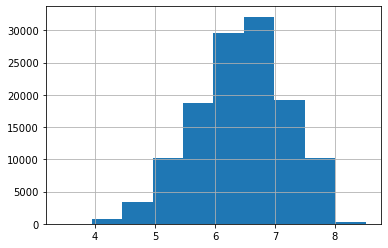

In [53]:
X_train.distance.hist();

In [194]:
X_train.head(1)

month  day_of_month  day_of_week unique_carrier origin dest  distance  \
0      4            16            4             OO    GEG  SLC  6.302619   

   hour  minutes  time_minute  
0    13        9          789

In [195]:
pd.concat((X_train, y_train), axis=1).corr('spearman')

month  day_of_month  day_of_week  distance      hour  \
month              1.000000      0.009467    -0.005678  0.007597 -0.005938   
day_of_month       0.009467      1.000000     0.002601  0.003942 -0.000846   
day_of_week       -0.005678      0.002601     1.000000  0.016914  0.001931   
distance           0.007597      0.003942     0.016914  1.000000 -0.029915   
hour              -0.005938     -0.000846     0.001931 -0.029915  1.000000   
minutes           -0.001879     -0.003238     0.002403 -0.004958 -0.077417   
time_minute       -0.006043     -0.001095     0.002220 -0.030084  0.998359   
dep_delayed_15min -0.041619     -0.001347    -0.010564  0.026328  0.220177   

                    minutes  time_minute  dep_delayed_15min  
month             -0.001879    -0.006043          -0.041619  
day_of_month      -0.003238    -0.001095          -0.001347  
day_of_week        0.002403     0.002220          -0.010564  
distance          -0.004958    -0.030084           0.026328  
hour              -0.077417     0.998359           0.220177  
minutes            1.000000    -0.021935          -0.022725  
time_minute       -0.021935     1.000000           0.219860  
dep_delayed_15min -0.022725     0.219860           1.000000

### Проверим улучшилась ли модель из-за доп признаков

In [101]:
%%time
res_time = do_train_test(X_train, y_train, ctb, random_seed=seed);
res_time

start | end
CPU times: user 3min 58s, sys: 22.8 s, total: 4min 21s
Wall time: 1min 10s


(0.8100562655044755, 0.7564308279445722)

In [197]:
baseline

(0.8018313309179812, 0.7555228286067397)

### Выделение часа улучшило корреляцию, но не добавило в точности, нужны дальнейшие менее очевидные преобразования

### Travel features

In [102]:
create_distance_features(X_train)

In [103]:
X_train.head(2)

month  day_of_month  day_of_week unique_carrier origin dest  distance  \
0      4            16            4             OO    GEG  SLC  6.302619   
1      3            11            3             UA    LAX  ORD  7.463937   

   target  hour  minutes  time_minute     path        path_by  
0       0    13        9          789  GEG-SLC  GEG-SLC by OO  
1       0    11       18          678  LAX-ORD  LAX-ORD by UA

In [104]:
%%time
res_travel = do_train_test(X_train, y_train, ctb, random_seed=seed)
res_travel

start | end
CPU times: user 5min 32s, sys: 26.9 s, total: 5min 59s
Wall time: 1min 37s


(0.8455216463576932, 0.767384092103965)

In [110]:
np.round([baseline, res_time, res_travel], 4)

array([[0.8018, 0.7555],
       [0.8101, 0.7564],
       [0.8455, 0.7674]])


### Проверим наше решение в Kaggle laderboard

In [137]:
X_train, y_train, X_test = get_data(True)

In [139]:
# лушче всего иметь функцию типа good_data = func3(func2(func1(raw_data)))

for data in (X_train, X_test):
    create_times_features(data)
    handle_distance(data)
    create_distance_features(data)

In [144]:
%%time
ctb.fit(X_train, y_train, cat_features=get_cat_features(X_train));

CPU times: user 7min 23s, sys: 32.7 s, total: 7min 55s
Wall time: 2min 7s


In [149]:
make_and_save_predict(ctb, X_test, 'simple_features.csv')

In [151]:
res_travel

(0.8455216463576932, 0.767384092103965)

### Получившийся результат: 0.77617, который коррелирует с тестом train test split
___

### Посмотрим на распределения задержек у компаний

In [355]:
df = pd.concat((X_train, y_train), axis=1)
df.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance  dep_delayed_15min  
0       546                  0

In [366]:
delay = pd.merge(
    df[df.dep_delayed_15min == 1][["unique_carrier", "dep_delayed_15min"]].groupby("unique_carrier").count(),
    df[["unique_carrier", "dep_delayed_15min"]].groupby("unique_carrier").count(),
    how="inner",
    left_on="unique_carrier",
    right_on="unique_carrier"
)
delay.columns = ["delay", "value"]
delay.head(2)

delay  value
unique_carrier              
AA               2574  15525
AS                424   3748

In [368]:
delay["part"] = (delay.delay / delay.value)
delay.head(2)

delay  value      part
unique_carrier                        
AA               2574  15525  0.165797
AS                424   3748  0.113127

In [369]:
delay.describe()

delay         value       part
count    14.000000     14.000000  14.000000
mean   1565.357143   8885.500000   0.172923
std    1457.114356   7693.418014   0.048890
min     131.000000   1306.000000   0.076296
25%     468.250000   2828.500000   0.144761
50%    1172.500000   5851.500000   0.166747
75%    2354.250000  12381.250000   0.207962
max    5544.000000  27098.000000   0.258921

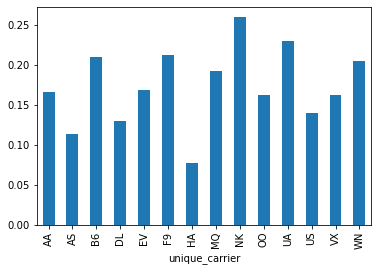

In [248]:
delay.part.plot(kind="bar")

Распределение не константное и имеет смысл создать такой признак, но т.к. мы работаем с целевой переменной то это не совсем хорошо, т.к. мы подстраиваемся под обучающую выборку

In [377]:
X_train_part = pd.merge(
    X_train,
    delay.part,
    how="left",
    left_on="unique_carrier",
    right_on="unique_carrier"
)

In [378]:
X_train_part.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance      part  
0       546  0.161489

In [379]:
%%time
do_train_test(X_train_part, y_train, ctb, random_seed=seed)

start | end
CPU times: user 3min 57s, sys: 24 s, total: 4min 21s
Wall time: 1min 10s


(0.79874553681249, 0.7534077422695237)

In [259]:
baseline

(0.8018313309179812, 0.7555228286067397)

### Не наблюдаемм улучшения качества.

### Проверим гипотезу про плохие направления

In [380]:
create_distance_features(df)

In [383]:
df.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance  dep_delayed_15min     path        path_by  
0       546                  0  GEG-SLC  GEG-SLC by OO

In [384]:
path = pd.merge(
    df[df.dep_delayed_15min == 1][["path", "distance"]].groupby("path").count(),
    df[["path", "distance"]].groupby("path").count(),
    how="inner",
    left_on="path",
    right_on="path"
)
path.columns = ["delay", "value"]

In [386]:
path["part"] = path.delay / path.value

In [388]:
pie = pd.merge(
    df,
    path.part,
    how="left",
    left_on="path",
    right_on="path"
)
pie.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance  dep_delayed_15min     path        path_by      part  
0       546                  0  GEG-SLC  GEG-SLC by OO  0.045455

In [393]:
# baseline with path feature
do_train_test(pd.concat((X_train, pie.path), axis=1), y_train, ctb)

start | end


(0.8150226997120301, 0.7532309258757648)

In [394]:
do_train_test(pd.concat((X_train, pie.path, pie.part), axis=1), y_train, ctb)

start | end


(0.804782313436999, 0.8244465993719676)

👀, проверим score на kaggle, т.к. разница слишком большая, но скорее всего мы просто переобучились

In [403]:
X_train_path = pd.concat((X_train, pie.path, pie.part), axis=1)
X_train_path.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance     path      part  
0       546  GEG-SLC  0.045455

In [406]:
%%time
ctb.fit(X_train_path, y_train, cat_features=get_cat_features(X_train_path));

CPU times: user 6min 17s, sys: 30.9 s, total: 6min 48s
Wall time: 1min 51s


In [402]:
X_test_path = X_test.copy()
X_test_path["path"] = X_test_path.origin + "-" + X_test_path.dest
X_test_path.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            19            7      1210             US    PHX  DEN   

   distance     path  
0       602  PHX-DEN

In [416]:
X_train_path.head(1)

month  day_of_month  day_of_week  dep_time unique_carrier origin dest  \
0      4            16            4      1309             OO    GEG  SLC   

   distance     path      part  
0       546  GEG-SLC  0.045455

In [418]:
X = pd.merge(
        X_test_path, path.part,
        how="left",
        left_on="path", right_on="path"
        )
make_and_save_predict(ctb, X, "path and part features.csv")

### Score - 0.71388

Как и ожидалось мы переобучились, и в некоторой степени показали что трогать целевую переменную при генерации признаков не стоит